In [4]:
#Code from https://github.com/qiskit-community/ibm-quantum-challenge-spring-2023/blob/main/solutions/lab_3/lab3_solution.ipynb

In [46]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from scipy.optimize import curve_fit
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

theta = 2*np.pi*(3/8)

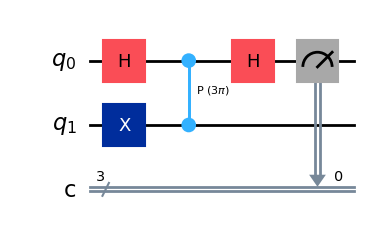

In [6]:
def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    ##1 Initialization

    q0, q1 = qr
    # apply Hadamard on the auxiliary qubit
    qc.h(q0)
    # put the system qubit into the |1> state
    qc.x(q1)

    ##2 Apply control-U operator as many times as needed to get the least significant phase bit

    # we want to apply controlled-S 2^k times
    k = 2
    # calculate the angle of CPhase corresponding to 2^k applications of angle
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##3 Measure the auxiliary qubit in x-basis into the first classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    c0, _, _ = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr, theta)
qc.draw("mpl")

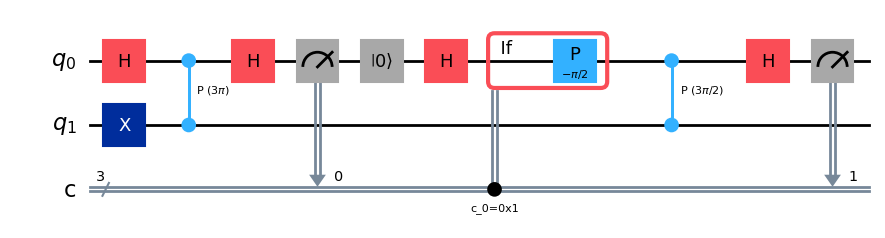

In [7]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr, angle)

    ########## your code goes here #######

    ##1 Reset and re-initialize the auxiliary qubit

    q0, q1 = qr
    # reset the auxiliary qubit
    qc.reset(q0)
    # apply Hadamard on the auxiiliary qubit
    qc.h(q0)

    ##2 Apply phase correction conditioned on the first classical bit

    c0, c1, _ = cr
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    ##3 Apply control-U operator as many times as needed to get the next phase bit

    # we want to apply controlled-S 2^k times
    k = 1
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##4 Measure the auxiliary qubit in x-basis into the second classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr, theta)
qc.draw("mpl")

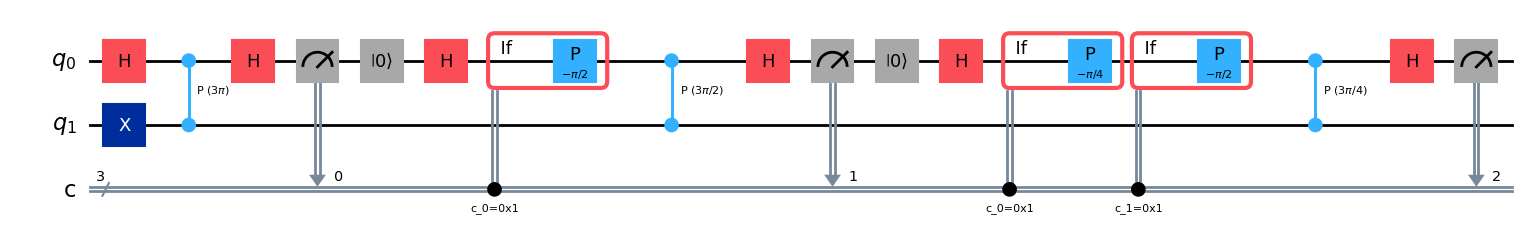

In [8]:
def step_3_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_2_circuit(qr, cr, angle)

    ########## your code goes here #######

    ##1 Reset and re-initialize the auxiliary qubit

    q0, q1 = qr
    # reset the auxiliary qubit
    qc.reset(q0)
    # apply Hadamard on the auxiiliary qubit
    qc.h(q0)

    ##2 Apply phase correction conditioned on the first classical bit

    c0, c1, c2 = cr
    with qc.if_test((c0, 1)):
        qc.p(-np.pi/4, q0)

    with qc.if_test((c1, 1)):
        qc.p(-np.pi/2, q0)

    ##3 Apply control-U operator as many times as needed to get the next phase bit

    # we want to apply controlled-S 2^k times
    k = 0
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##4 Measure the auxiliary qubit in x-basis into the second classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    qc.measure(q0, c2)

    return qc

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_3_circuit(qr, cr, theta)
qc.draw("mpl")

In [9]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'011': 1000}

In [10]:
def iqpe(angle: float, steps: int):
    if steps == 1:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(3, "c")
        return step_1_circuit(qr,cr,angle)                  #funktioniert!!! (step_1_circuit will immer genau 3 classical registers haben, also zwei sind "überflüssuig", das kommt noch von mir, als ich den set_3 erweitert habe)
    else:
        qr = QuantumRegister(2,"q")
        cr = ClassicalRegister(steps, "c")
        q0, q1 = qr

        list = []
        for i in range(97, 97+steps):                               #hier die Liste mit dem Classical Register: Nachteil geht nur von A-Z, d.h. maximal 26 Steps, aber kann man theoretisch beliebig erweitern
            list.append("{:c}".format(i))
        list = cr  

        qc = QuantumCircuit(qr,cr)

        # apply Hadamard on the auxiliary qubit                                             
        qc.h(q0)
        # put the system qubit into the |1> state
        qc.x(q1)
        ##2 Apply control-U operator as many times as needed to get the least significant phase bit
        # we want to apply controlled-S 2^k times
        k = steps-1
        # calculate the angle of CPhase corresponding to 2^k applications of angle
        cphase_angle = angle * 2**k
        # apply the controlled phase gate
        qc.cp(cphase_angle, q0, q1)
        ##3 Measure the auxiliary qubit in x-basis into the first classical bit
        # apply Hadamard to change to the X basis
        qc.h(q0)
        # measure the auxiliary qubit into the first classical bit
                                 
        qc.measure(q0, list[0])                                                                                                     #Bis hier, nur step_1_cicuit

        for i in range(1,steps):                                                                                                    #Ab hier, gehts weiter über die for schleife
            qc.reset(q0)
            # apply Hadamard on the auxiiliary qubit
            qc.h(q0)

            ##2 Apply phase correction conditioned on the first classical bit

            for j in range(i):
                with qc.if_test((list[j], 1)):
                    qc.p((-2*np.pi)/(2**(i-j+1)), q0)

            ##3 Apply control-U operator as many times as needed to get the next phase bit

            # we want to apply controlled-S 2^k times
            k = steps - i - 1
            # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
            cphase_angle = angle * 2**k
            # apply the controlled phase gate
            qc.cp(cphase_angle, q0, q1)

            ##4 Measure the auxiliary qubit in x-basis into the second classical bit

            # apply Hadamard to change to the X basis
            qc.h(q0)
            # measure the auxiliary qubit into the first classical bit
            qc.measure(q0, list[i])
        
        return qc
#Funktioniert
def convert(bin: str):
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n
#Funktioniert
def mean(x: list, y: list):


    m = 0
    total = 0
    for i in range(len(x)):
        m += x[i]*y[i]
        total += y[i]
    m = m*(1/total)
    return m
#Funktioniert
def diff_with_max(x: list, y: list, angle: float):
    ind = 0
    max_element = y[0]
    for i in range (1,len(y)):
        if y[i] > max_element:
            max_element = y[i]
            ind = i
    diff_max = np.abs(x[ind] - angle)
    return diff_max

{'011': 666, '010': 183, '001': 32, '100': 57, '000': 11, '111': 13, '110': 22, '101': 16}
Success probability: 0.666


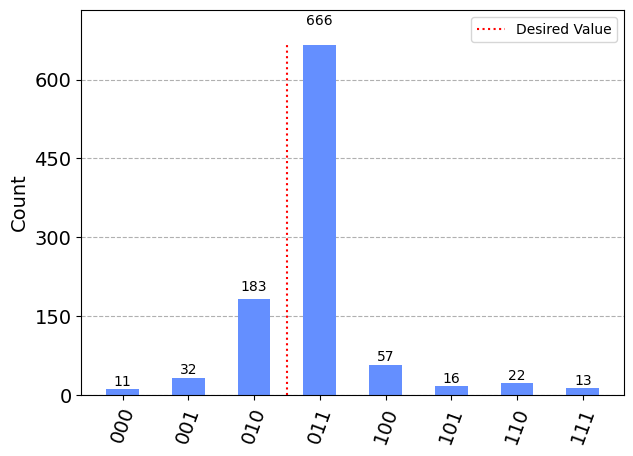

In [11]:
depth = 3
angle = 0.33
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e3)
result = job.result()
counts = result.get_counts()
print(counts)


success_probability = counts["011"] / counts.shots()          #https://www.rapidtables.com/convert/number/decimal-to-binary.html   0.25 --> 0.01 --> 010...000 ,erste 0 fällt weg
print(f"Success probability: {success_probability}")


fig, ax1 = plt.subplots(figsize=(7,5))

ax1 = plot_histogram(counts, ax = ax1)

plt.vlines(2.5 , 0 , max(counts.values()), color = "red", linestyle = "dotted", label = "Desired Value")
plt.legend()
plt.show()


{'10000': 382, '01010': 56, '01110': 5714, '10010': 62, '00100': 10, '01101': 464, '10001': 160, '01111': 2545, '11100': 12, '00000': 5, '10101': 27, '01100': 148, '10100': 35, '01011': 76, '11011': 17, '00111': 21, '11110': 7, '10011': 51, '11111': 11, '00011': 14, '01001': 33, '10110': 19, '11001': 16, '01000': 19, '11010': 10, '11000': 17, '00101': 16, '00110': 16, '00010': 11, '10111': 8, '11101': 11, '00001': 7}
Success probability: 0.5714


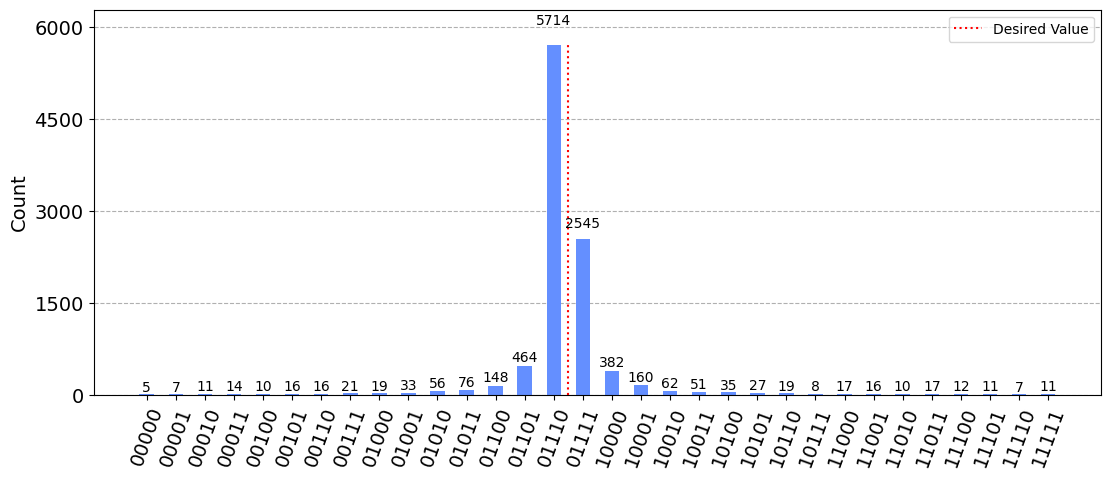

In [12]:
depth = 5
angle = 0.45
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e4)
result = job.result()
counts = result.get_counts()
print(counts)


success_probability = counts["01110"] / counts.shots()          #https://www.rapidtables.com/convert/number/decimal-to-binary.html   0.25 --> 0.01 --> 010...000 ,erste 0 fällt weg
print(f"Success probability: {success_probability}")


fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plot_histogram(counts, ax = ax1)

plt.vlines(14.5 , 0 , max(counts.values()), color = "red", linestyle = "dotted", label = "Desired Value")
plt.legend()
plt.show()


{'100': 4950, '011': 64412, '010': 20773, '110': 1356, '101': 1969, '111': 1220, '000': 1679, '001': 3641}


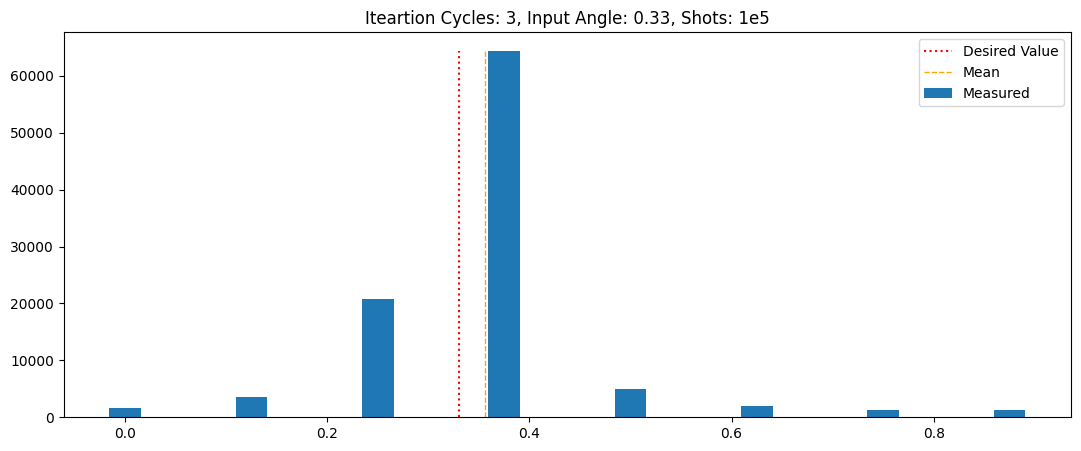

Difference between Mean of Mesurement and Desired Value:  0.02593000000000001
Theoretical precision of QPE with the same depth:  0.125
Improvement by  4.820671037408406

 Difference between Maximum Value of Mesurement and Desired Value:  0.044999999999999984
Improvement by  2.7777777777777786


In [13]:
depth = 3
angle = 0.33
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e5)
result = job.result()
counts = result.get_counts()
print(counts)

keys = counts.keys()
values = counts.values()

keys = [convert(i) for i in keys]
values = [i for i in values]

#print(keys)
#print(values)

fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plt.bar(keys, values, width = 2**(-depth-2), label="Measured")

avg = mean(keys, values)

plt.vlines(angle , 0 , max(values), color = "red", linestyle = "dotted", label = "Desired Value")
plt.vlines(avg, 0 , max(values), color='orange', linestyle='dashed', linewidth=1, label = "Mean")
plt.title("Iteartion Cycles: 3, Input Angle: 0.33, Shots: 1e5")

plt.legend()
plt.show()

diff = np.abs(avg-angle)
print("Difference between Mean of Mesurement and Desired Value: ", diff)
theory = 2**(-depth)
print("Theoretical precision of QPE with the same depth: ", theory)
print("Improvement by ", theory/diff)

diff_max = diff_with_max(keys, values, angle)
print("\n Difference between Maximum Value of Mesurement and Desired Value: ", diff_max)
print("Improvement by ", theory/diff_max)

{'01110': 57314, '00101': 149, '00110': 146, '01111': 25467, '10011': 504, '01101': 4693, '10000': 3568, '10010': 706, '10001': 1434, '01011': 798, '10101': 262, '01100': 1620, '11001': 127, '11010': 139, '10100': 305, '01000': 254, '00001': 95, '01001': 371, '01010': 490, '10110': 202, '10111': 161, '11011': 92, '11000': 139, '00111': 188, '00100': 123, '00011': 95, '11110': 101, '11111': 90, '00010': 111, '11101': 77, '00000': 98, '11100': 81}


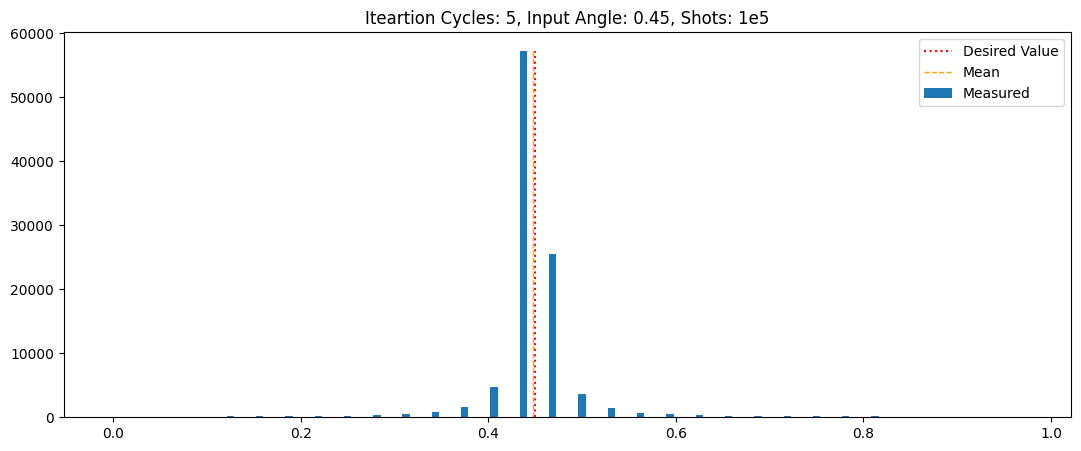

Difference between Mean of Mesurement and Desired Value:  0.0017628124999999883
Theoretical precision of QPE with the same depth:  0.03125
Improvement by  17.72735330615151

 Difference between Maximum Value of Mesurement and Desired Value:  0.012500000000000011
Improvement by  2.499999999999998


In [14]:
depth = 5
angle = 0.45
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e5)
result = job.result()
counts = result.get_counts()
print(counts)

keys = counts.keys()
values = counts.values()

keys = [convert(i) for i in keys]
values = [i for i in values]

#print(keys)
#print(values)

fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plt.bar(keys, values, width = 2**(-depth-2), label="Measured")

avg= mean(keys, values)

plt.vlines(angle , 0 , max(values), color = "red", linestyle = "dotted", label = "Desired Value")
plt.vlines(avg, 0 , max(values), color='orange', linestyle='dashed', linewidth=1, label = "Mean")
plt.title("Iteartion Cycles: 5, Input Angle: 0.45, Shots: 1e5")

plt.legend()
plt.show()

diff = np.abs(avg-angle)
print("Difference between Mean of Mesurement and Desired Value: ", diff)
theory = 2**(-depth)
print("Theoretical precision of QPE with the same depth: ", theory)
print("Improvement by ", theory/diff)


diff_max = diff_with_max(keys, values, angle)
print("\n Difference between Maximum Value of Mesurement and Desired Value: ", diff_max)
print("Improvement by ", theory/diff_max)

{'10100011': 98358, '10111001': 1, '10100000': 47, '10100100': 550, '10100010': 429, '10100101': 119, '10110100': 3, '10100111': 28, '10011101': 27, '10100001': 140, '11011011': 1, '10011110': 34, '10011011': 15, '11001110': 1, '01111010': 1, '10011100': 10, '10101100': 6, '10011111': 37, '01001001': 1, '10100110': 58, '11010110': 1, '10010001': 3, '00100000': 1, '10101101': 5, '10101000': 24, '10000010': 1, '10110000': 1, '10010010': 1, '01111100': 1, '10101001': 13, '10011010': 4, '10110001': 2, '10010101': 3, '10101010': 14, '10011001': 3, '10010000': 1, '01110010': 1, '10101111': 2, '10101011': 7, '10110111': 1, '10000101': 1, '10111000': 4, '11111101': 2, '10111011': 1, '10101110': 4, '10111101': 1, '00101111': 1, '00010101': 1, '10010100': 2, '11101011': 1, '11000000': 1, '10010110': 3, '10001010': 1, '10111100': 1, '10001100': 2, '10000100': 1, '10110110': 2, '10010011': 1, '10011000': 1, '10110101': 2, '10001101': 1, '00100110': 1, '10010111': 2, '01101101': 1, '10001000': 3, '

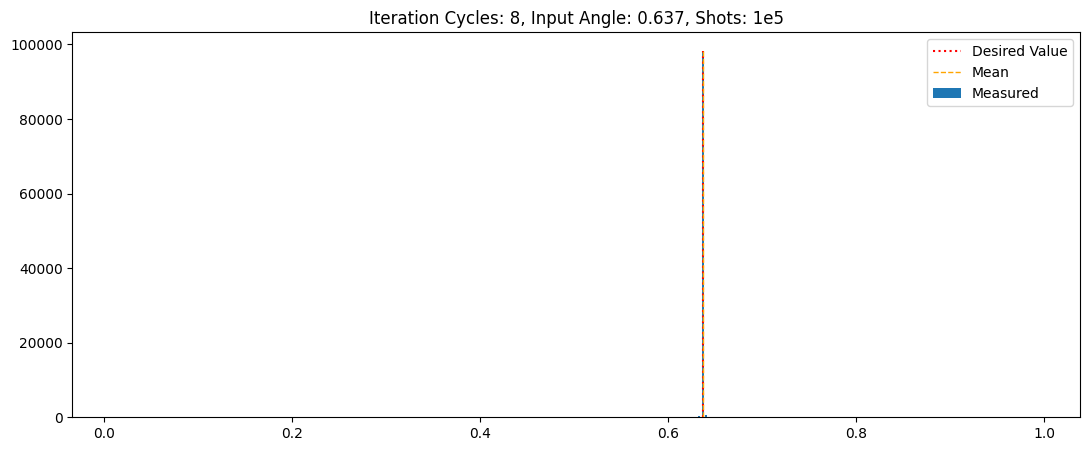

Difference between Mean of Mesurement and Desired Value:  0.00031027343750000824
Theoretical precision of QPE with the same depth:  0.00390625
Improvement by  12.589701624071175

 Difference between Maximum Value of Mesurement and Desired Value:  0.00028125000000001066
Improvement by  13.888888888888362


In [15]:
depth = 8
angle = 0.637
theta = 2*np.pi*angle
qc = iqpe(theta,depth)
#qc.draw("mpl")

from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1e5)
result = job.result()
counts = result.get_counts()
print(counts)

keys = counts.keys()
values = counts.values()

keys = [convert(i) for i in keys]
values = [i for i in values]

#print(keys)
#print(values)

fig, ax1 = plt.subplots(figsize=(13,5))

ax1 = plt.bar(keys, values, width = 2**(-depth-1), label="Measured")

avg= mean(keys, values)

plt.vlines(angle , 0 , max(values), color = "red", linestyle = "dotted", label = "Desired Value")
plt.vlines(avg, 0 , max(values), color='orange', linestyle='dashed', linewidth=1, label = "Mean")
plt.title("Iteration Cycles: 8, Input Angle: 0.637, Shots: 1e5")

plt.legend()
plt.show()

diff = np.abs(avg-angle)
print("Difference between Mean of Mesurement and Desired Value: ", diff)
theory = 2**(-depth)
print("Theoretical precision of QPE with the same depth: ", theory)
print("Improvement by ", theory/diff)

diff_max = diff_with_max(keys, values, angle)
print("\n Difference between Maximum Value of Mesurement and Desired Value: ", diff_max)
print("Improvement by ", theory/diff_max)

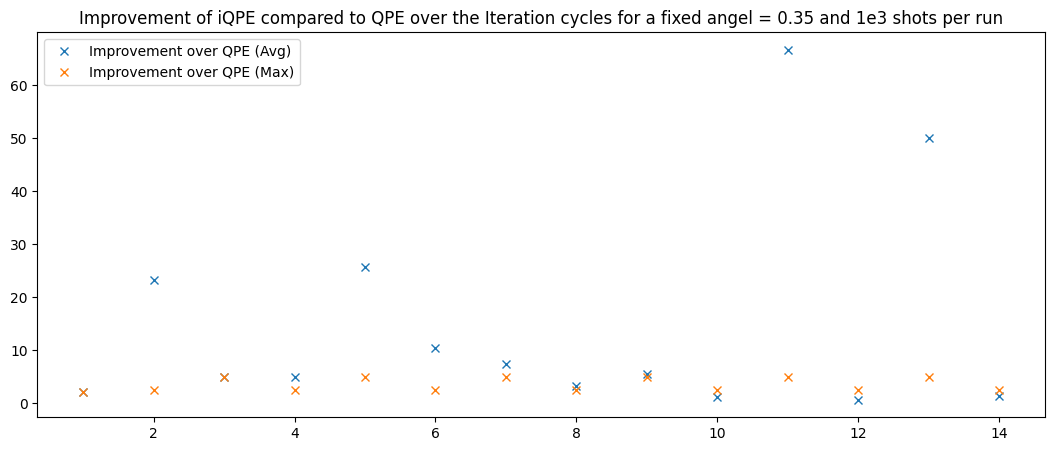

In [35]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit der Depth für fixed Winkel (Abwichung zum Average und zum Maximum Value)

overview = 15
angle = 0.35
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1,overview):
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e3)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over the Iteration cycles for a fixed angel = 0.35 and 1e3 shots per run")
plt.legend()

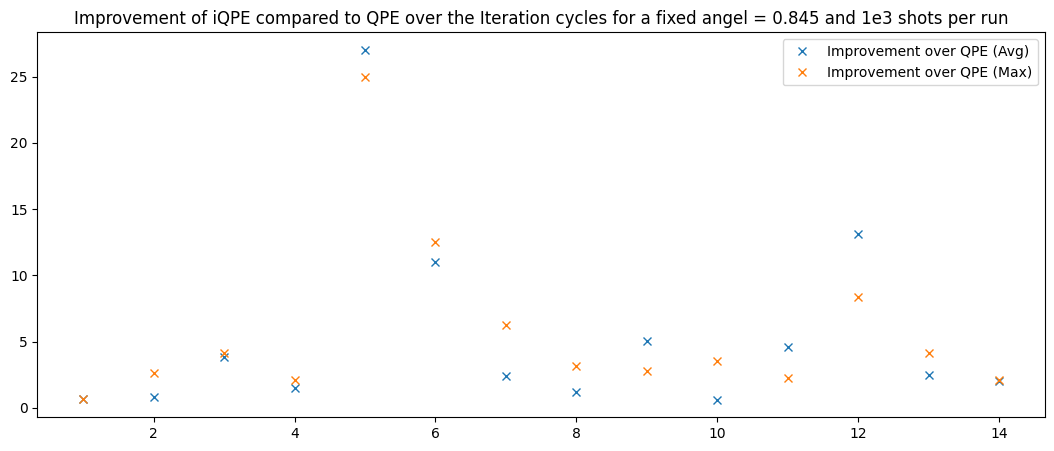

In [29]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit der Depth für fixed Winkel (Abwichung zum Average und zum Maximum Value)

overview = 15
angle = 0.845
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1,overview):
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e3)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over the Iteration cycles for a fixed angel = 0.845 and 1e3 shots per run")
plt.legend()

C:\Users\Dustin\AppData\Local\Temp\ipykernel_21624\4053244138.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  improve_avg = theory/diff
C:\Users\Dustin\AppData\Local\Temp\ipykernel_21624\4053244138.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  improve_max= theory/diff_max


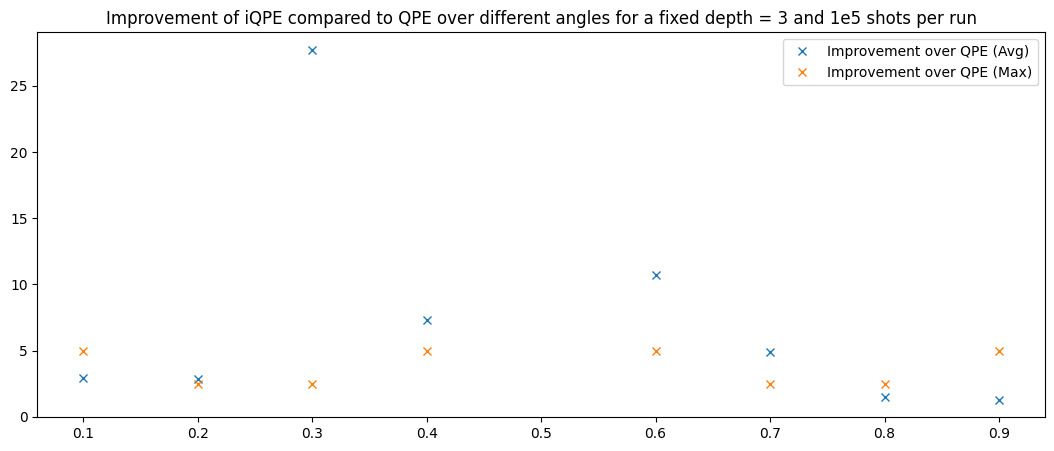

In [18]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit des Winkels für fixed Depth (Abwichung zum Average und zum Maximum Value)

depth = 3
slices = 20
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1, slices):
    angle = (1/slices)*i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e5)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(angle)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over different angles for a fixed depth = 3 and 1e5 shots per run")
plt.legend()

C:\Users\Dustin\AppData\Local\Temp\ipykernel_21624\2573364266.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  improve_avg = theory/diff
C:\Users\Dustin\AppData\Local\Temp\ipykernel_21624\2573364266.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  improve_max= theory/diff_max


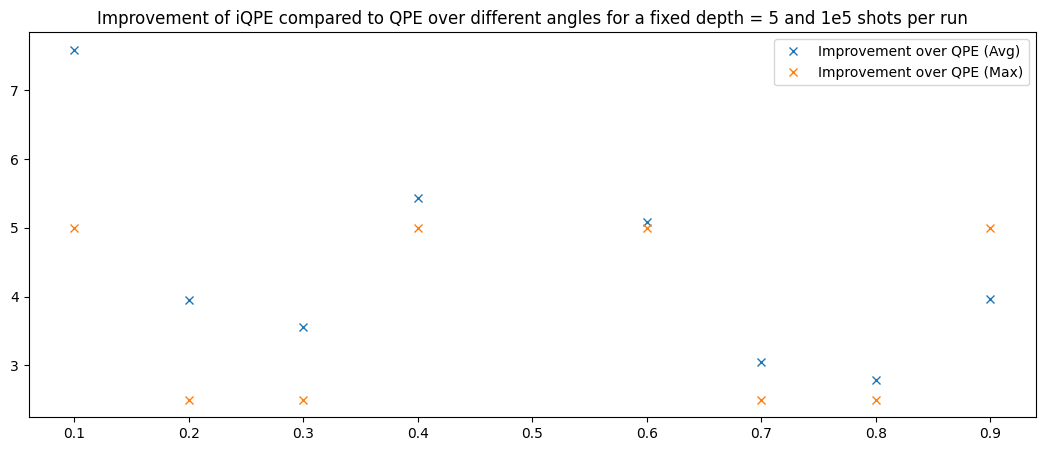

In [19]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit des Winkels für fixed Depth (Abwichung zum Average und zum Maximum Value)

depth = 5
slices = 20
list_improve_avg = []
list_improve_max = []
x = []
for i in range(1, slices):
    angle = (1/slices)*i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e5)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg= mean(keys, values)
    diff = np.abs(avg-angle)
    theory = 2**(-depth)

    improve_avg = theory/diff
    list_improve_avg.append(improve_avg)

    diff_max = diff_with_max(keys, values, angle)
    improve_max= theory/diff_max
    list_improve_max.append(improve_max)

    x.append(angle)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_improve_avg, "x", label="Improvement over QPE (Avg)")
ax = plt.plot(x, list_improve_max, "x", label="Improvement over QPE (Max)")
plt.title("Improvement of iQPE compared to QPE over different angles for a fixed depth = 5 and 1e5 shots per run")
plt.legend()

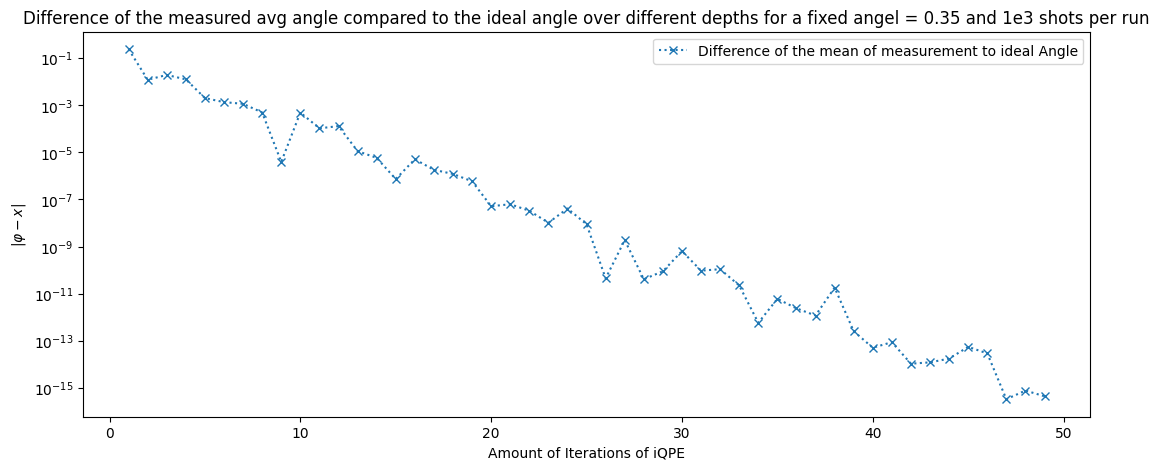

In [41]:
#Plotte Abweichung zum gesuchten Winkel in Abhängigkeit der Depth für fixed Winkel (So wie Leons Plot)

overview = 50
angle = 0.35
list_diff = []
list_diff_max  = []
x = []
for i in range(1,overview):
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    job = sim.run(qc, shots=1e3)
    result = job.result()
    counts = result.get_counts()

    keys = counts.keys()
    values = counts.values()

    keys = [convert(i) for i in keys]
    values = [i for i in values]
    avg = mean(keys, values)
    diff = np.abs(avg-angle)
    list_diff.append(diff)

    diff_max = diff_with_max(keys, values, angle)
    list_diff_max.append(diff_max)

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_diff, "x", label="Difference of the mean of measurement to ideal Angle", linestyle = "dotted")
#ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

plt.title("Difference of the measured avg angle compared to the ideal angle over different depths for a fixed angel = 0.35 and 1e3 shots per run")
plt.yscale("log")
plt.ylabel(r"$\vert \varphi - x \vert$")
plt.xlabel("Amount of Iterations of iQPE")
plt.legend()
#plt.savefig("test2.png", dpi = 300)
plt.show()

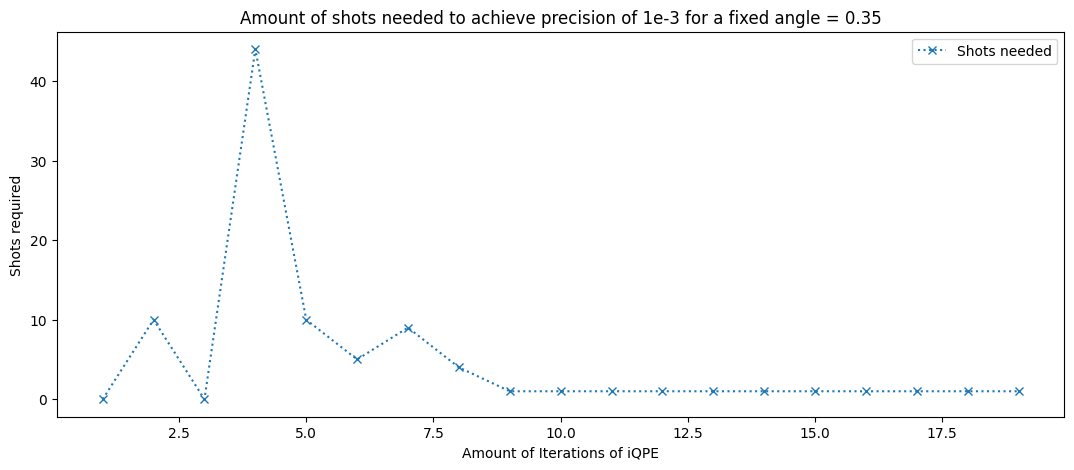

In [86]:
#Plot: Bei geforderter Präzision, wie reduziert sich die Anzahl der benötigten Shots geplotted über die Tiefe

overview = 20
angle = 0.35
precision = 1e-3
list_shots = []
x = []
for i in range(1,overview):
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    maxshots = 1e3
    for k in range(1,int(maxshots)):
        job = sim.run(qc, shots=k)
        result = job.result()
        counts = result.get_counts()

        keys = counts.keys()
        values = counts.values()

        keys = [convert(i) for i in keys]
        values = [i for i in values]
        avg = mean(keys, values)
        diff = np.abs(avg-angle)
        if diff <= precision:
            list_shots.append(k)
            break
        elif k==maxshots-1:
            list_shots.append(0)
            break
        else:
            continue

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_shots, "x", label="Shots needed", linestyle = "dotted")
#ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

plt.title("Amount of shots needed to achieve precision of 1e-3 for a fixed angle = 0.35")
#plt.yscale("log")
plt.ylabel("Shots required")
plt.xlabel("Amount of Iterations of iQPE")
plt.legend()
#plt.savefig("test2.png", dpi = 300)
plt.show()

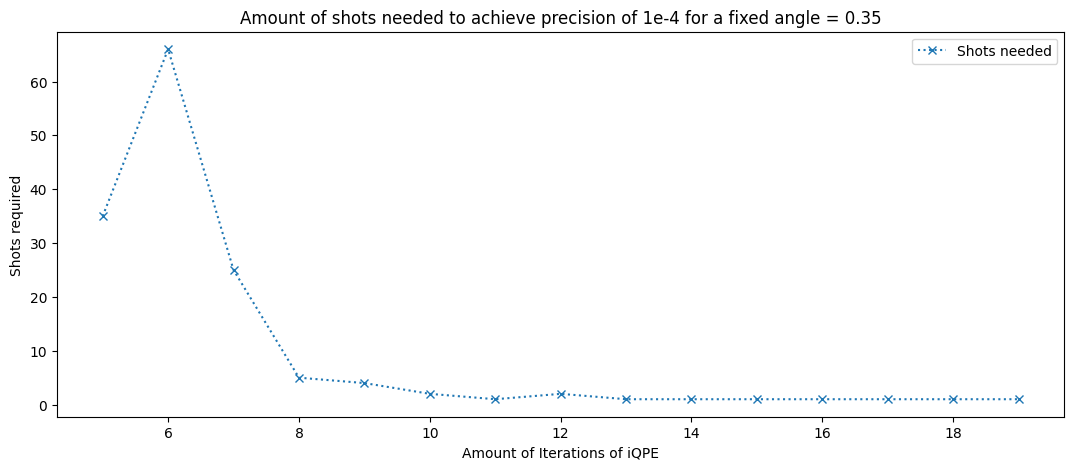

In [92]:
#Plot: Bei geforderter Präzision, wie reduziert sich die Anzahl der benötigten Shots geplotted über die Tiefe

overview = 20
angle = 0.35
precision = 1e-4
list_shots = []
x = []
for i in range(5,overview):                                 #ab depth = 5 bekomme ich garantiert die 1e-4 precision, davor ist es Glückssache
    depth = i
    theta = 2*np.pi*angle
    qc = iqpe(theta,depth)

    sim = AerSimulator()
    maxshots = 1e4
    for k in range(1,int(maxshots)):
        job = sim.run(qc, shots=k)
        result = job.result()
        counts = result.get_counts()

        keys = counts.keys()
        values = counts.values()

        keys = [convert(i) for i in keys]
        values = [i for i in values]
        avg = mean(keys, values)
        diff = np.abs(avg-angle)
        if diff <= precision:
            list_shots.append(k)
            break
        elif k==maxshots-1:
            list_shots.append(0)
            break
        else:
            continue

    x.append(i)

fig, ax = plt.subplots(figsize=(13,5))

ax = plt.plot(x, list_shots, "x", label="Shots needed", linestyle = "dotted")
#ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

plt.title("Amount of shots needed to achieve precision of 1e-4 for a fixed angle = 0.35")
#plt.yscale("log")
plt.ylabel("Shots required")
plt.xlabel("Amount of Iterations of iQPE")
plt.legend()
#plt.savefig("test5.png", dpi = 300)
plt.show()

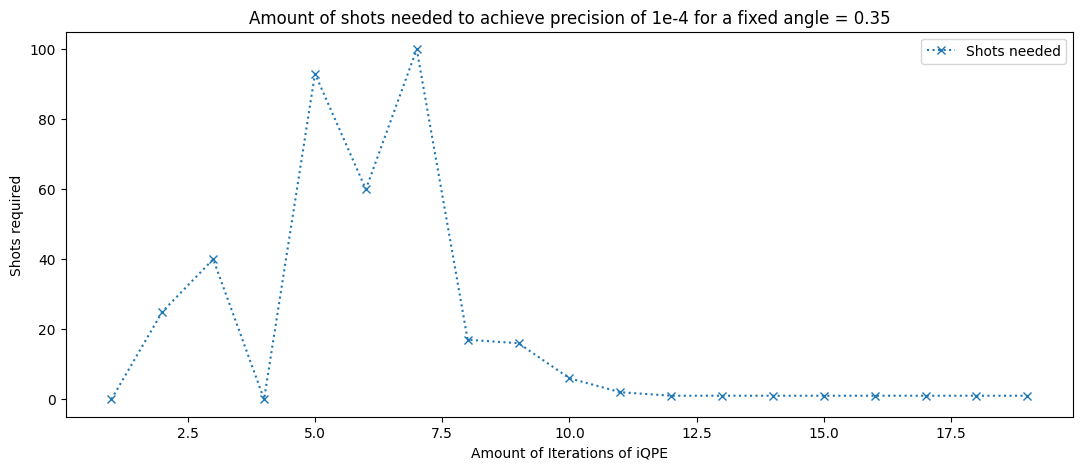

In [96]:
#Plot: Bei geforderter Präzision, wie reduziert sich die Anzahl der benötigten Shots geplotted über die Tiefe


def plot_requ_prec(precision: float, depth_range:int, angle: float):

    list_shots = []
    x = []
    for i in range(1,depth_range):                                 #ab depth = 5 bekomme ich garantiert die 1e-4 precision, davor ist es Glückssache
        depth = i
        theta = 2*np.pi*angle
        qc = iqpe(theta,depth)

        sim = AerSimulator()
        maxshots = 1e4
        for k in range(1,int(maxshots)):
            job = sim.run(qc, shots=k)
            result = job.result()
            counts = result.get_counts()

            keys = counts.keys()
            values = counts.values()

            keys = [convert(i) for i in keys]
            values = [i for i in values]
            avg = mean(keys, values)
            diff = np.abs(avg-angle)
            if diff <= precision:
                list_shots.append(k)
                break
            elif k==maxshots-1:
                list_shots.append(0)
                break
            else:
                continue

        x.append(i)

    fig, ax = plt.subplots(figsize=(13,5))

    ax = plt.plot(x, list_shots, "x", label="Shots needed", linestyle = "dotted")
    #ax = plt.plot(x, list_diff, "x", label="Difference of the max of measurement to ideal Angle", linestyle = "dotted")                #basically the same as with average

    plt.title("Amount of shots needed to achieve precision of 1e-4 for a fixed angle = 0.35")
    #plt.yscale("log")
    plt.ylabel("Shots required")
    plt.xlabel("Amount of Iterations of iQPE")
    plt.legend()
    #plt.savefig("test5.png", dpi = 300)
    return plt.show()

plot_requ_prec(1e-4,20,0.45)